# Modeling Credit Risk with Lending Club data

### Outline

1. Business problem and summary of results
2. Data import.
3. Data preprocessing.
4. EDA.
5. Sample split, missing values and feature engineering.
6. Modeling.
7. Interpretation of the results.
8. Business implications.

#### Objective: Predict delinquency of a borrower
#### Metric: ROCAUC or PRAUC


The biggest question re this data is which features are pulled at origination time.
For the details on this, see stuff below:
- https://www.kaggle.com/datasets/wordsforthewise/lending-club/discussion/220358
- https://www.kaggle.com/code/tysonpo/columns-available-at-origination-answer/notebook

From those links above, it seems that most features are pulled at loan application/origination. 
The only features, pulled later, belong to the two groups:
- features, related to loan performance/payments.
- features, which clearly mention this in name/description. E.g., word 'last' in feature name.

Notes:
Address is a key feature. Try to get it. Zip_code from address wil dramatically improve results.
And use ohe for more cat features.

### Business Problem

### Objective

### Summary of Results

## 2. Data import

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, time, warnings, gzip, gc, random, math, shap, pickle, optuna, csv, sys, re
from IPython.display import display
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 400)

warnings.filterwarnings("ignore")

In [33]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [34]:
time0 = time.time()

with open('../input/lc-sample850k/LCLoans_sample850k.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)
    
display(df.head())

features_tokeep = ['id', 'loan_status',
 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment','issue_d',
 'purpose', 'title', 'initial_list_status', 'application_type',
 'grade', 'sub_grade', 'fico_range_high',
 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'zip_code', 'addr_state',
 'dti',           
 'verification_status', 
 'mo_sin_rcnt_tl', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record',
 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq',
 'num_tl_op_past_12m', 
 'earliest_cr_line', 'inq_last_6mths', 'inq_fi', 'inq_last_12m',
 'open_acc', 'acc_open_past_24mths', 'mort_acc', 'total_acc',
 'avg_cur_bal', 'il_util', 'tot_cur_bal', 
 'revol_bal', 'revol_util', 'max_bal_bc', 'bc_open_to_buy', 'mo_sin_rcnt_rev_tl_op', 'num_actv_rev_tl', 'num_op_rev_tl', 'total_rev_hi_lim',               
 'delinq_2yrs', 'acc_now_delinq', 'delinq_amnt', 'pub_rec', 'pub_rec_bankruptcies',
 'annual_inc_joint', 'dti_joint', 'verification_status_joint',
 'total_bal_ex_mort', 'tot_coll_amt', 'tax_liens', 'percent_bc_gt_75', 'pct_tl_nvr_dlq', 
 'open_rv_12m', 'open_il_12m', 'num_tl_90g_dpd_24m', 'num_tl_30dpd', 'num_tl_120dpd_2m',
 'num_accts_ever_120_pd',
 'recoveries']

df = df[features_tokeep]

recoveries = df[['id', 'recoveries', 'loan_amnt', 'int_rate']]

df.drop(columns = ['recoveries'], inplace=True)
df.drop(columns = ['il_util', 'max_bal_bc'], inplace=True)
# these are useful features, which I will preprocess later

df.issue_d = df.issue_d.astype('O')
df.issue_d = pd.to_datetime(df.issue_d, format='%b-%Y')
df['year_issued']=df.issue_d.dt.year
#df = df[df.year_issued.isin([2018])]
    
df = df.sample(200000)
df.reset_index(inplace=True, drop=True)
display(df.shape, time.time()-time0, df.head())

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
2,1077175,2400.0,2400.0,2400.0,36.0,15.96,84.330002,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3005.666748,3005.669922,2400.000000,605.669983,0.0,0.000000,0.00,Jun-2014,649.909973,NaN,Jun-2017,739.0,735.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
8,1071795,5600.0,5600.0,5600.0,60.0,21.28,152.389999,F,F2,NaN,4 years,OWN,40000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Expand Business & Buy Debt Portfolio,958xx,CA,5.55,0.0,Apr-2004,675.0,679.0,2.0,NaN,NaN,11.0,0.0,5210.0,32.6,13.0,f,0.0,0.0,647.500000,647.500000,162.020004,294.940002,0.0,190.539993,2.09,Apr-2012,152.389999,NaN,Oct-2016,499.0,0.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
11,1069908,12000.0,12000.0,12000.0,36.0,12.69,402.540009,B,B5,UCLA,10+ years,OWN,75000.0,Source Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Consolidation,913xx,CA,1

(200000, 68)

1.7144253253936768

,id,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued
0,140414621,Current,4000.0,4000.0,4000.0,36.0,7.84,125.059998,2018-10-01,debt_consolidation,Debt consolidation,w,Individual,A,A4,729.0,Supervisor,9 years,MORTGAGE,49000.0,352xx,AL,24.860001,Not Verified,12.0,71.0,71.0,NaN,NaN,71.0,1.0,Sep-2000,0.0,2.0,1.0,10.0,3.0,3.0,22.0,8686.0,69487.0,3366.0,33.3,4656.0,24.0,2.0,6.0,10100.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,24130.0,0.0,0.0,0.0,90.900002,0.0,1.0,0.0,0.0,0.0,2.0,2018.0
1,54515145,Fully Paid,28000.0,28000.0,28000.0,36.0,6.24,854.869995,2015-07-01,credit_card,Credit card refinancing,w,Individual,A,A2,719.0,Systems Engineer,5 years,MORTGAGE,135000.0,214xx,MD,11.290000,Source Verified,8.0,59.0,59.0,NaN,NaN,NaN,2.0,Jan-1989,0.0,NaN,NaN,14.0,5.0,8.0,31.0,54204.0,704647.0,41964.0,64.0,20973.0,8.0,8.0,9.0,65600.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,57180.0,0.0,0.0,50.0,93.500000,NaN,NaN,0.0,0.0,0.0,2.0,2015.0
2,38456961,Fully Paid,5000.0,5000.0,5000.0,36.0,8.67,158.240005,2015-01-01,major_purchase,Major purchase,f,Individual,B,B1,679.0,truck driver,10+ years,RENT,65000.0,488xx,MI,15.120000,Source Verified,4.0,NaN,NaN,74.0,NaN,NaN,2.0,Jan-1995,2.0,NaN,NaN,6.0,4.0,1.0,17.0,6268.0,31338.0,3332.0,40.1,617.0,4.0,2.0,4.0,8300.0,0.0,0.0,0.0,2.0,2.0,NaN,NaN,NaN,31338.0,0.0,0.0,100.0,100.000000,NaN,NaN,0.0,0.0,0.0,0.0,2015.0
3,10071757,Fully Paid,15000.0,15000.0,14975.0,60.0,16.99,372.709991,2014-01-01,debt_consolidation,Debt consolidation,f,Individual,D,D1,674.0,Produce Manager,10+ years,RENT,47000.0,532xx,WI,7.430000,Source Verified,9.0,51.0,52.0,40.0,NaN,NaN,1.0,Jan-1999,0.0,NaN,NaN,9.0,4.0,0.0,15.0,1252.0,11266.0,11190.0,62.5,3550.0,9.0,7.0,8.0,17900.0,0.0,0.0,0.0,3.0,0.0,NaN,NaN,NaN,11266.0,0.0,0.0,25.0,93.300003,NaN,NaN,0.0,0.0,0.0,0.0,2014.0
4,104092170,Charged Off,10000.0,10000.0,10000.0,36.0,23.99,392.279999,2017-04-01,home_improvement,Home improvement,f,Individual,E,E2,699.0,Buyer,10+ years,MORTGAGE,50000.0,333xx,FL,17.280001,Source Verified,1.0,27.0,52.0,NaN,NaN,NaN,3.0,Apr-2006,2.0,2.0,5.0,8.0,8.0,2.0,13.0,10375.0,83003.0,2604.0,42.0,2086.0,1.0,5.0,5.0,6200.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,21284.0,0.0,0.0,0.0,84.599998,3.0,0.0,0.0,0.0,0.0,1.0,2017.0


## 3. Data preprocessing

In [35]:
### feature description:

#f_desc = pd.read_excel('../input/lending-club-20072020q1/LCDataDictionary.xlsx')
#f_desc.columns = ['colname','desc']
#display(f_desc.head())
#display(f_desc)
#display(f_desc.loc[f_desc.colname=='open_acc','desc'], f_desc.loc[f_desc.colname=='total_acc','desc'])

In [36]:
# remove some very rarae loan types:

df = df[~df.purpose.isin(['educational', 'renewable_energy', 'wedding'])]
df.purpose = df.purpose.cat.remove_categories(['educational', 'renewable_energy', 'wedding'])


In [37]:
# clean time features

df.earliest_cr_line = df.earliest_cr_line.astype('O')
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line, format='%b-%Y')
df['month_issued']=df.issue_d.dt.month
df['year_earliest']=df.issue_d.dt.year
df['years_borrowing'] = (df.issue_d - df.earliest_cr_line)/ np.timedelta64(1, 'Y')
df['pub_rec_pa'] = df.pub_rec/df.years_borrowing
display(df.head())

,id,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa
0,140414621,Current,4000.0,4000.0,4000.0,36.0,7.84,125.059998,2018-10-01,debt_consolidation,Debt consolidation,w,Individual,A,A4,729.0,Supervisor,9 years,MORTGAGE,49000.0,352xx,AL,24.860001,Not Verified,12.0,71.0,71.0,NaN,NaN,71.0,1.0,2000-09-01,0.0,2.0,1.0,10.0,3.0,3.0,22.0,8686.0,69487.0,3366.0,33.3,4656.0,24.0,2.0,6.0,10100.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,24130.0,0.0,0.0,0.0,90.900002,0.0,1.0,0.0,0.0,0.0,2.0,2018.0,10.0,2018.0,18.081138,0.000000
1,54515145,Fully Paid,28000.0,28000.0,28000.0,36.0,6.24,854.869995,2015-07-01,credit_card,Credit card refinancing,w,Individual,A,A2,719.0,Systems Engineer,5 years,MORTGAGE,135000.0,214xx,MD,11.290000,Source Verified,8.0,59.0,59.0,NaN,NaN,NaN,2.0,1989-01-01,0.0,NaN,NaN,14.0,5.0,8.0,31.0,54204.0,704647.0,41964.0,64.0,20973.0,8.0,8.0,9.0,65600.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,57180.0,0.0,0.0,50.0,93.500000,NaN,NaN,0.0,0.0,0.0,2.0,2015.0,7.0,2015.0,26.494726,0.000000
2,38456961,Fully Paid,5000.0,5000.0,5000.0,36.0,8.67,158.240005,2015-01-01,major_purchase,Major purchase,f,Individual,B,B1,679.0,truck driver,10+ years,RENT,65000.0,488xx,MI,15.120000,Source Verified,4.0,NaN,NaN,74.0,NaN,NaN,2.0,1995-01-01,2.0,NaN,NaN,6.0,4.0,1.0,17.0,6268.0,31338.0,3332.0,40.1,617.0,4.0,2.0,4.0,8300.0,0.0,0.0,0.0,2.0,2.0,NaN,NaN,NaN,31338.0,0.0,0.0,100.0,100.000000,NaN,NaN,0.0,0.0,0.0,0.0,2015.0,1.0,2015.0,20.000411,0.099998
3,10071757,Fully Paid,15000.0,15000.0,14975.0,60.0,16.99,372.709991,2014-01-01,debt_consolidation,Debt consolidation,f,Individual,D,D1,674.0,Produce Manager,10+ years,RENT,47000.0,532xx,WI,7.430000,Source Verified,9.0,51.0,52.0,40.0,NaN,NaN,1.0,1999-01-01,0.0,NaN,NaN,9.0,4.0,0.0,15.0,1252.0,11266.0,11190.0,62.5,3550.0,9.0,7.0,8.0,17900.0,0.0,0.0,0.0,3.0,0.0,NaN,NaN,NaN,11266.0,0.0,0.0,25.0,93.300003,NaN,NaN,0.0,0.0,0.0,0.0,2014.0,1.0,2014.0,15.000992,0.199987
4,104092170,Charged Off,10000.0,10000.0,10000.0,36.0,23.99,392.279999,2017-04-01,home_improvement,Home improvement,f,Individual,E,E2,699.0,Buyer,10+ years,MORTGAGE,50000.0,333xx,FL,17.280001,Source Verified,1.0,27.0,52.0,NaN,NaN,NaN,3.0,2006-04-01,2.0,2.0,5.0,8.0,8.0,2.0,13.0,10375.0,83003.0,2604.0,42.0,2086.0,1.0,5.0,5.0,6200.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,21284.0,0.0,0.0,0.0,84.599998,3.0,0.0,0.0,0.0,0.0,1.0,2017.0,4.0,2017.0,11.000910,0.000000


In [38]:
# creating a target variable

display(df.loan_status.value_counts())
df.target=np.nan
#df.loc[df.loan_status.isin(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']), 'target']=0
#df.loc[df.loan_status.isin(['Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default']), 'target']=1
df.loc[df.loan_status.isin(['Fully Paid']), 'target']=0
df.loc[df.loan_status.isin(['Charged Off', 'Default']), 'target']=1
df=df[df['target'].isin([0,1])]
display(df.shape,df.loan_status.value_counts(), df.count(), sys.getsizeof(df)/1048576)
df.drop(columns='loan_status',inplace=True)

Fully Paid                                             98868
Current                                                72666
Charged Off                                            25693
Late (31-120 days)                                      1180
In Grace Period                                          725
Late (16-30 days)                                        191
Issued                                                   143
Does not meet the credit policy. Status:Fully Paid       136
Does not meet the credit policy. Status:Charged Off       45
Default                                                   37
Name: loan_status, dtype: int64

(124598, 73)

Fully Paid                                             98868
Charged Off                                            25693
Default                                                   37
Current                                                    0
Does not meet the credit policy. Status:Charged Off        0
Does not meet the credit policy. Status:Fully Paid         0
In Grace Period                                            0
Issued                                                     0
Late (16-30 days)                                          0
Late (31-120 days)                                         0
Name: loan_status, dtype: int64

id                                124598
loan_status                       124598
loan_amnt                         124598
funded_amnt                       124598
funded_amnt_inv                   124598
term                              124598
int_rate                          124598
installment                       124598
issue_d                           124598
purpose                           124598
title                             123212
initial_list_status               124598
application_type                  124598
grade                             124598
sub_grade                         124598
fico_range_high                   124598
emp_title                         116113
emp_length                        117004
home_ownership                    124598
annual_inc                        124598
zip_code                          124598
addr_state                        124598
dti                               124522
verification_status               124598
mo_sin_rcnt_tl  

85.92990684509277

### 3. Feature Preprocessing

In [39]:
# add key loan features
df.loc[df.annual_inc<1,'annual_inc']=1
df['lti']=df.loan_amnt/df.annual_inc
df['iti']=(df.installment*12)/df.annual_inc
df.loc[df.lti==np.inf, 'lti']=np.nan
df.loc[df.lti>1.5, 'lti']=1.5
df.loc[df.iti==np.inf, 'iti']=np.nan
df.loc[df.iti>1, 'iti']=1
df.loc[df.revol_util>100,'revol_util']=100
df.loc[df.dti>100, 'dti']=100
df.loc[df.dti<0, 'dti']=0

# add more features

df['zip_code'] = df.zip_code.str.rstrip('xx').astype(int)
df['joint'] = df.dti_joint.notnull().astype(int)

df['emp_length'] = df.emp_length.str.rstrip(' years')
df.loc[df.emp_length=='< 1','emp_length'] = 0
df.loc[df.emp_length=='10+','emp_length'] = 10
df['emp_length'] = df.emp_length.astype(np.float32)
display(df.emp_length.value_counts())

df.amnt_same = (df.loan_amnt == df.funded_amnt_inv).astype(int)
df['revol_balance_income'] = df.revol_bal/df.annual_inc
df['avg_cur_bal_inc'] = df.avg_cur_bal/df.annual_inc
df['tot_cur_bal_inc'] = df.tot_cur_bal/df.annual_inc
df['total_bal_ex_mort_inc'] = df.total_bal_ex_mort/df.annual_inc
df['total_rev_inc'] = df.total_rev_hi_lim/df.annual_inc

df['low_fico'] = (df.fico_range_high<=659).astype(int)
df['open_cl_ratio']=df.open_acc/df.total_acc
df.loc[df.home_ownership.isin(['ANY','NONE','OTHER']), 'home_ownership'] = 'OTHER'
df['was_bankrupt'] = (df.pub_rec_bankruptcies>0).astype(int)

df.drop(columns = ['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'earliest_cr_line', 'issue_d'], inplace=True)

df.head()

10.0    41197
2.0     11335
0.0     10289
3.0      9895
1.0      8300
5.0      7848
4.0      7475
6.0      5698
8.0      5192
7.0      5158
9.0      4617
Name: emp_length, dtype: int64

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
1,54515145,28000.0,28000.0,28000.0,36.0,6.24,854.869995,credit_card,Credit card refinancing,w,Individual,A,A2,719.0,Systems Engineer,5.0,MORTGAGE,135000.0,214,MD,11.290000,Source Verified,8.0,59.0,59.0,NaN,NaN,NaN,2.0,0.0,NaN,NaN,14.0,5.0,8.0,31.0,54204.0,704647.0,41964.0,64.0,20973.0,8.0,8.0,9.0,65600.0,0.0,0.0,0.0,0.0,0.0,57180.0,0.0,0.0,50.000000,93.500000,NaN,NaN,0.0,0.0,0.0,2.0,2015.0,7.0,2015.0,26.494726,0.000000,0.0,0.207407,0.075988,0,0.310844,0.401511,5.219607,0.423556,0.485926,0,0.451613,0
2,38456961,5000.0,5000.0,5000.0,36.0,8.67,158.240005,major_purchase,Major purchase,f,Individual,B,B1,679.0,truck driver,10.0,RENT,65000.0,488,MI,15.120000,Source Verified,4.0,NaN,NaN,74.0,NaN,NaN,2.0,2.0,NaN,NaN,6.0,4.0,1.0,17.0,6268.0,31338.0,3332.0,40.1,617.0,4.0,2.0,4.0,8300.0,0.0,0.0,0.0,2.0,2.0,31338.0,0.0,0.0,100.000000,100.000000,NaN,NaN,0.0,0.0,0.0,0.0,2015.0,1.0,2015.0,20.000411,0.099998,0.0,0.076923,0.029214,0,0.051262,0.096431,0.482123,0.482123,0.127692,0,0.352941,1
3,10071757,15000.0,15000.0,14975.0,60.0,16.99,372.709991,debt_consolidation,Debt consolidation,f,Individual,D,D1,674.0,Produce Manager,10.0,RENT,47000.0,532,WI,7.430000,Source Verified,9.0,51.0,52.0,40.0,NaN,NaN,1.0,0.0,NaN,NaN,9.0,4.0,0.0,15.0,1252.0,11266.0,11190.0,62.5,3550.0,9.0,7.0,8.0,17900.0,0.0,0.0,0.0,3.0,0.0,11266.0,0.0,0.0,25.000000,93.300003,NaN,NaN,0.0,0.0,0.0,0.0,2014.0,1.0,2014.0,15.000992,0.199987,0.0,0.319149,0.095160,0,0.238085,0.026638,0.239702,0.239702,0.380851,0,0.600000,0
4,104092170,10000.0,10000.0,10000.0,36.0,23.99,392.279999,home_improvement,Home improvement,f,Individual,E,E2,699.0,Buyer,10.0,MORTGAGE,50000.0,333,FL,17.280001,Source Verified,1.0,27.0,52.0,NaN,NaN,NaN,3.0,2.0,2.0,5.0,8.0,8.0,2.0,13.0,10375.0,83003.0,2604.0,42.0,2086.0,1.0,5.0,5.0,6200.0,0.0,0.0,0.0,0.0,0.0,21284.0,0.0,0.0,0.000000,84.599998,3.0,0.0,0.0,0.0,0.0,1.0,2017.0,4.0,2017.0,11.000910,0.000000,1.0,0.200000,0.094147,0,0.052080,0.207500,1.660060,0.425680,0.124000,0,0.615385,0
6,83344250,2400.0,2400.0,2400.0,36.0,11.49,79.139999,vacation,Vacation,w,Individual,B,B5,674.0,Correction Officer,7.0,OWN,65000.0,124,NY,24.020000,Verified,8.0,23.0,23.0,NaN,NaN,NaN,5.0,0.0,2.0,2.0,16.0,14.0,1.0,24.0,11994.0,191908.0,31592.0,58.1,5914.0,8.0,9.0,13.0,54400.0,1.0,0.0,0.0,0.0,0.0,51317.0,0.0,0.0,33.299999,95.800003,4.0,0.0,1.0,0.0,0.0,1.0,2016.0,6.0,2016.0,12.501283,0.000000,0.0,0.036923,0.014610,0,0.486031,0.184523,2.952431,0.789492,0.836923,0,0.666667,0


In [40]:
# For features like 'time_since some credit event', treat NA as never and fill those values with 100 years equivalent

df.mo_sin_rcnt_tl = df.mo_sin_rcnt_tl.fillna(value=120)
df.num_tl_op_past_12m = df.num_tl_op_past_12m.fillna(value=0)

months_since_col = ['mths_since_last_delinq', 'mths_since_last_major_derog', 
                    'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq']

for col in months_since_col:
    df[col] = df[col].fillna(value=1200)

display(df.count())

df.inq_fi = df.inq_fi.fillna(value=0)
df.inq_last_12m = df.inq_last_12m.fillna(value=0)



id                                124598
loan_amnt                         124598
funded_amnt                       124598
funded_amnt_inv                   124598
term                              124598
int_rate                          124598
installment                       124598
purpose                           124598
title                             123212
initial_list_status               124598
application_type                  124598
grade                             124598
sub_grade                         124598
fico_range_high                   124598
emp_title                         116113
emp_length                        117004
home_ownership                    124598
annual_inc                        124598
zip_code                          124598
addr_state                        124598
dti                               124522
verification_status               124598
mo_sin_rcnt_tl                    124598
mths_since_last_delinq            124598
mths_since_last_

In [41]:
df.mo_sin_rcnt_tl.describe()

count    124598.000000
mean         12.211969
std          22.801481
min           0.000000
25%           3.000000
50%           6.000000
75%          11.000000
max         260.000000
Name: mo_sin_rcnt_tl, dtype: float64

In [42]:
df.target.mean()

0.2065041172410472

In [43]:
cat_features_te = ['sub_grade', 'emp_title', 'purpose', 'title', 'zip_code', 'addr_state', 'grade', 'home_ownership']
cat_features_ohe = ['verification_status', 'initial_list_status', 'application_type']

In [44]:
df.application_type.value_counts()

Individual    120058
Joint App       4540
Name: application_type, dtype: int64

### 4. EDA

In [45]:
print('Bankruptcy incidnce is the sample is: ', df.target.mean())

Bankruptcy incidnce is the sample is:  0.2065041172410472


In [46]:
display(df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv']].describe())
display(df.term.value_counts())

,loan_amnt,funded_amnt,funded_amnt_inv
count,124598.000000,124598.000000,124598.000000
mean,14485.012695,14479.546875,14462.867188
std,8967.159180,8964.666016,8965.646484
min,1000.000000,1000.000000,0.000000
25%,7600.000000,7600.000000,7500.000000
50%,12000.000000,12000.000000,12000.000000
75%,20000.000000,20000.000000,20000.000000
max,40000.000000,40000.000000,40000.000000


36.0    95426
60.0    29172
Name: term, dtype: int64

So the three amount features above are basically identical.

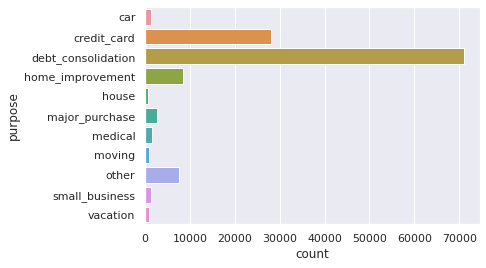

<AxesSubplot:xlabel='count', ylabel='emp_length'>

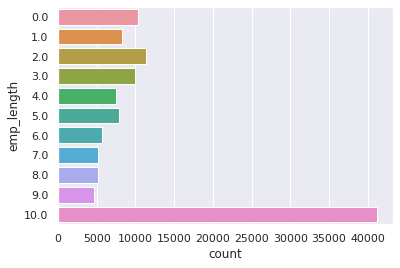

In [47]:
sns.countplot(y='purpose', data=df)
plt.show()
sns.countplot(y='emp_length', data=df)

In [48]:
#top_titles = (df.title.value_counts()[:10]).index
#tempdf = df[df.title.isin(list(top_titles))]
#sns.countplot(y='title', data=tempdf)

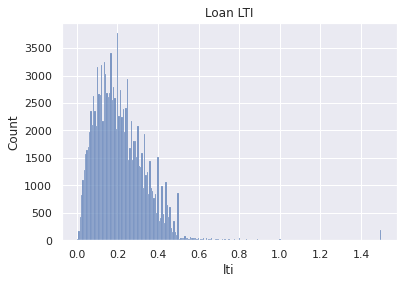

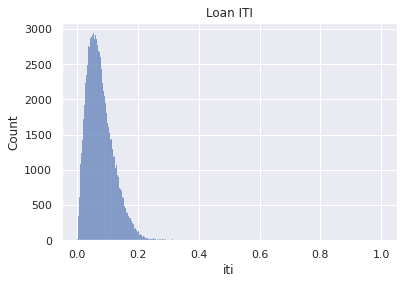

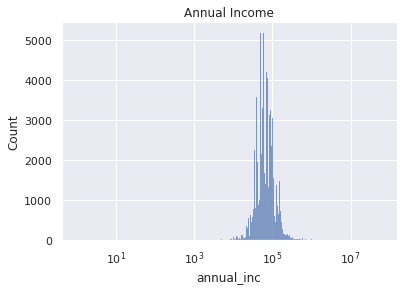

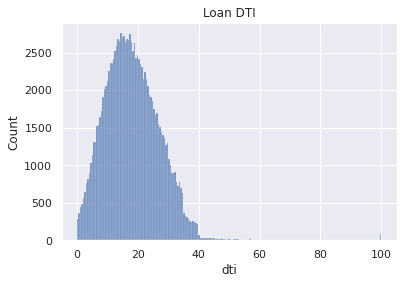

In [49]:
#sns.histplot(x='int_rate', data=df).set(title='Loan LTI')
#plt.show()
sns.histplot(x='lti', data=df).set(title='Loan LTI')
plt.show()
sns.histplot(x='iti', data=df).set(title='Loan ITI')
plt.show()
sns.histplot(x='annual_inc', data=df, log_scale=True).set(title='Annual Income')
plt.show()
sns.histplot(x='dti', data=df).set(title='Loan DTI')
plt.show()

In [50]:
df.dti.describe()

count    124522.000000
mean         18.284821
std           9.216537
min           0.000000
25%          11.740000
50%          17.549999
75%          24.080000
max         100.000000
Name: dti, dtype: float64

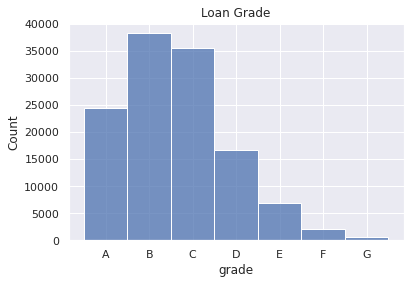

In [51]:
sns.histplot(x='grade', data=df).set(title='Loan Grade')
plt.show()

### EDA with target

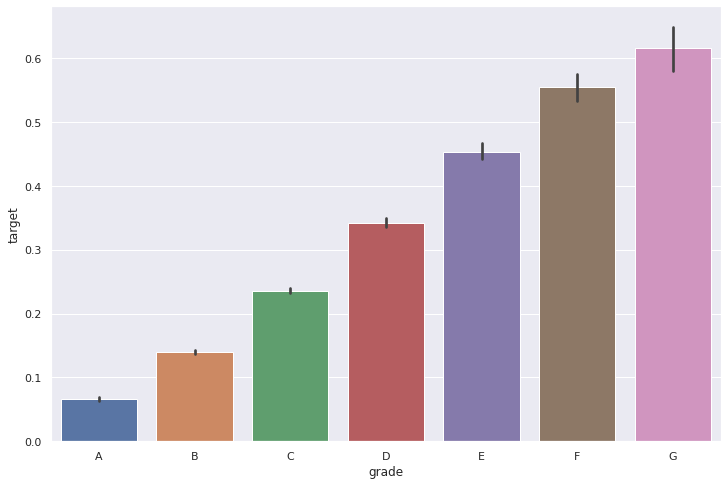

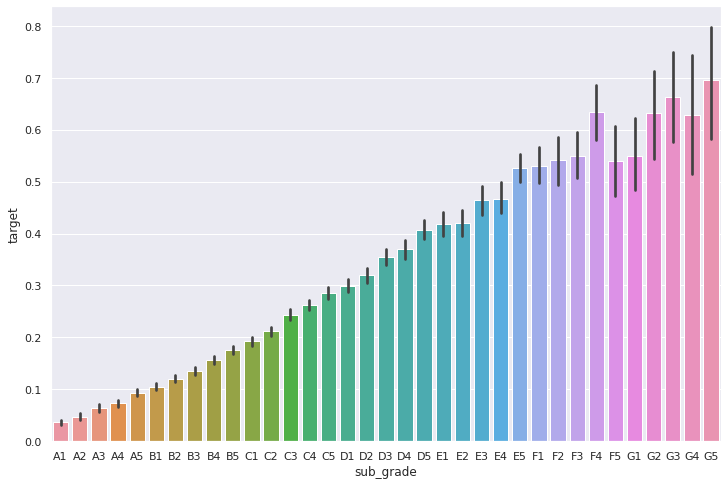

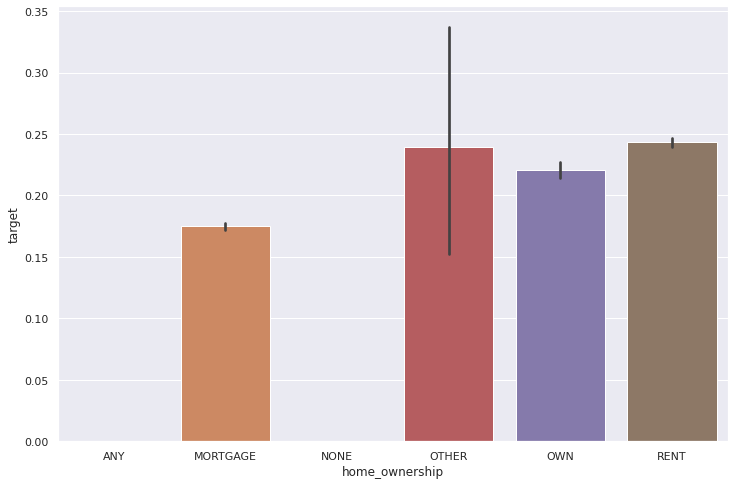

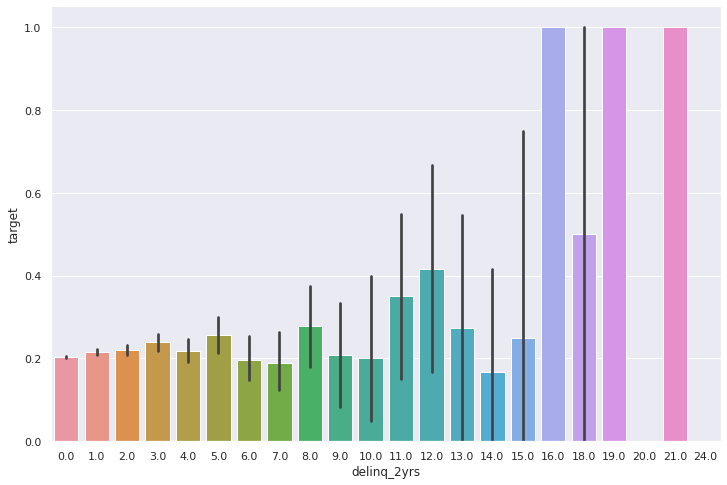

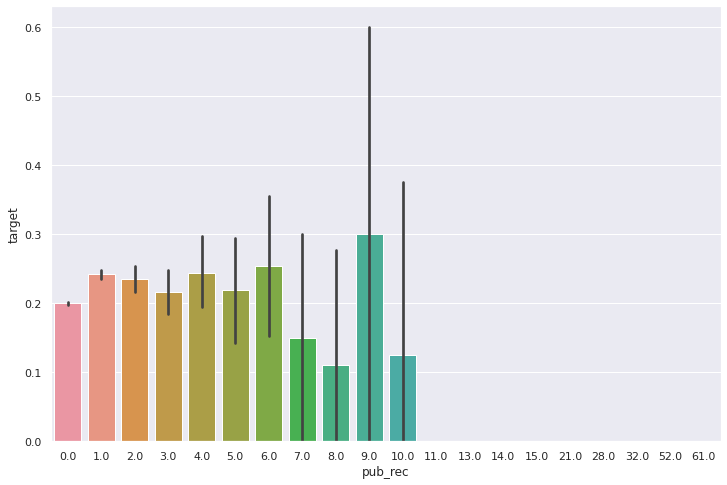

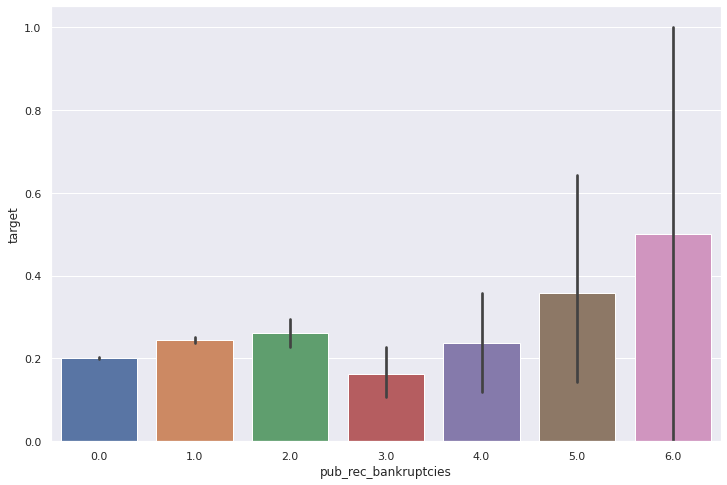

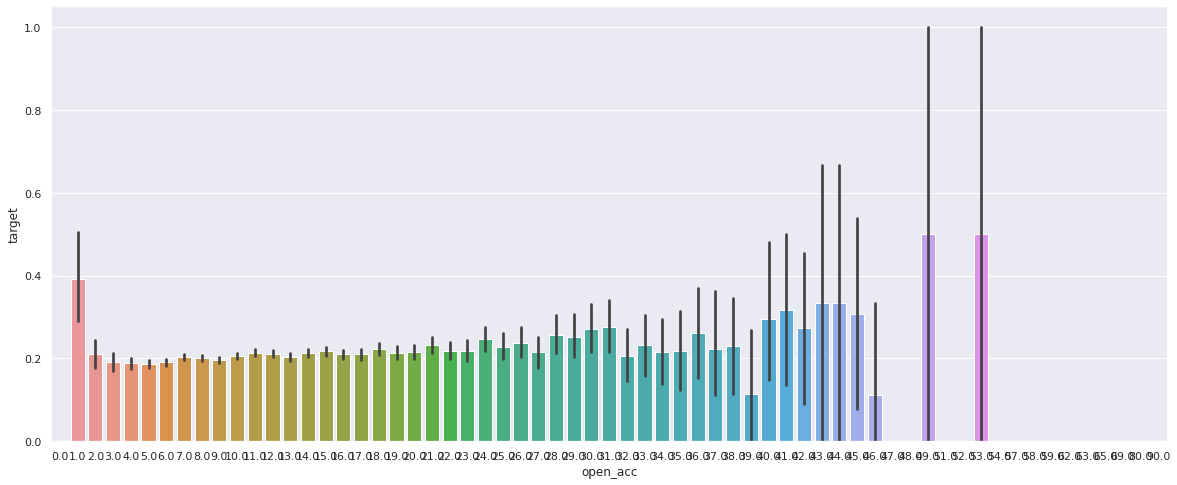

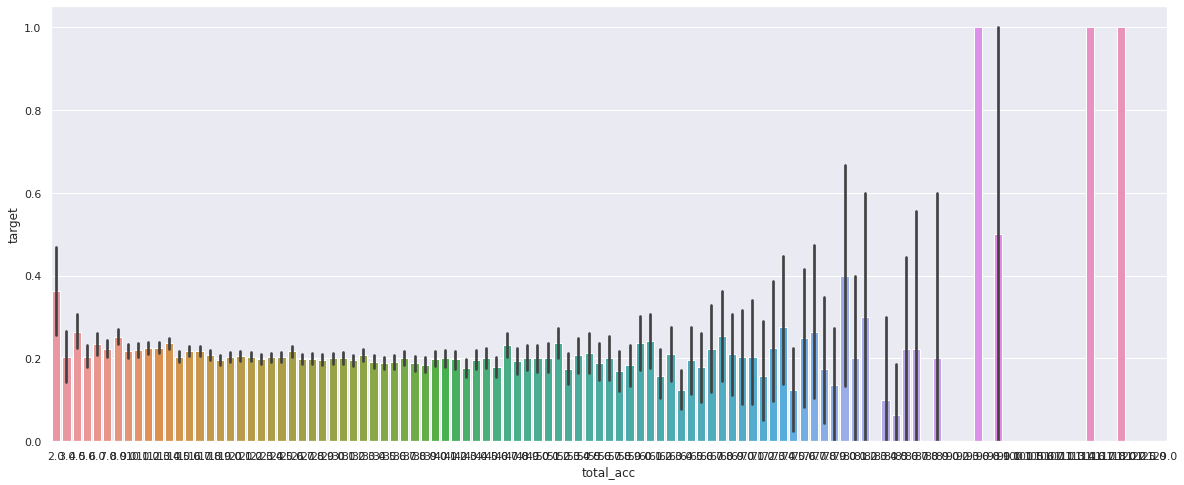

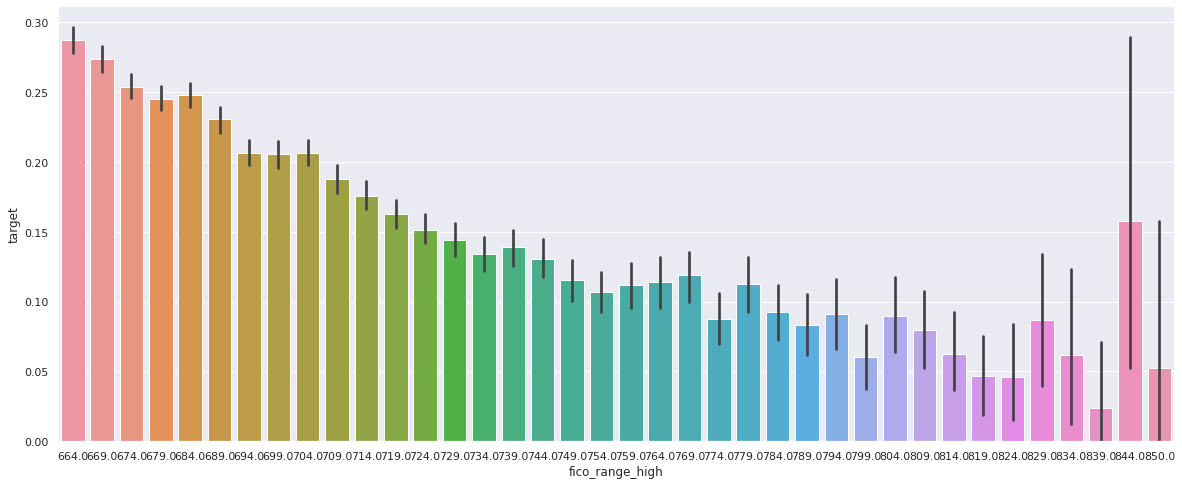

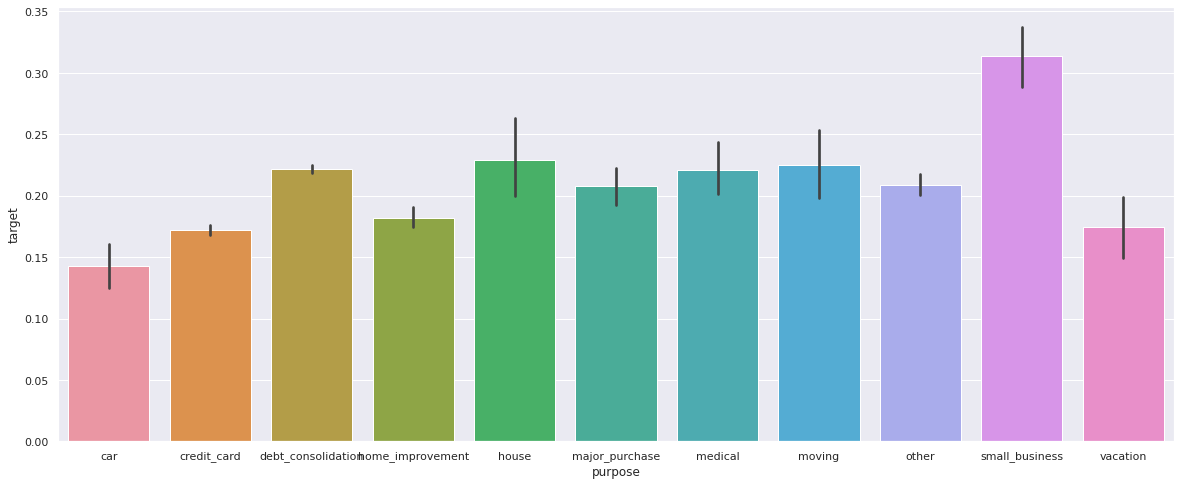

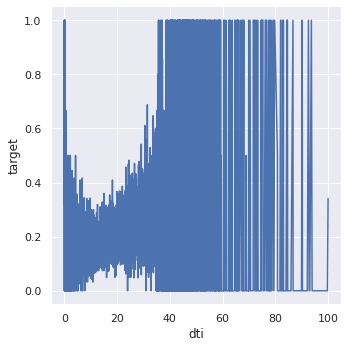

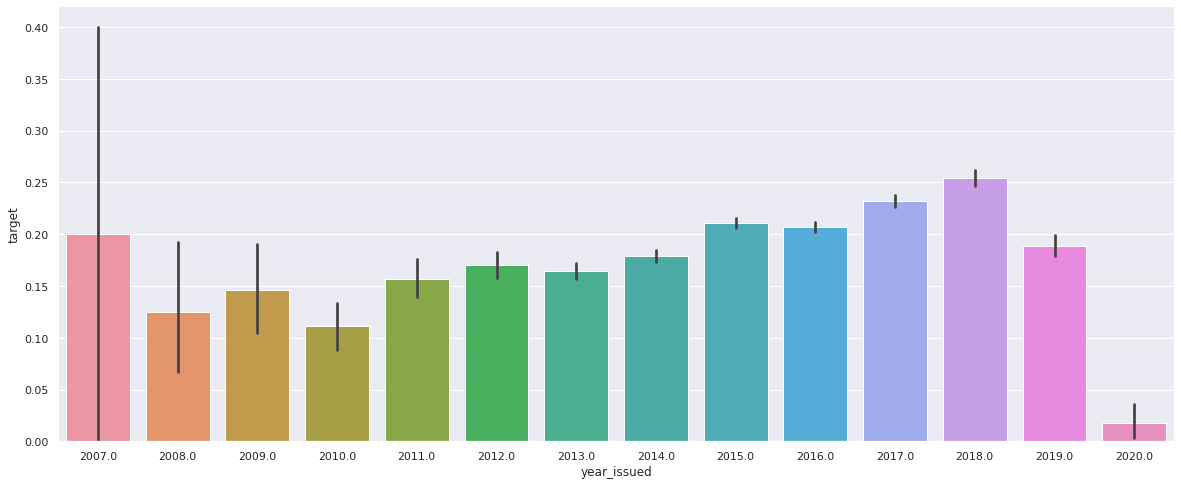

In [52]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x='grade', y='target', data=df)
plt.show()
sns.barplot(x='sub_grade', y='target', data=df)
plt.show()
sns.barplot(x='home_ownership', y='target', data=df)
plt.show()
sns.barplot(x='delinq_2yrs', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec_bankruptcies', y='target', data=df)
plt.show()
sns.set(rc={'figure.figsize':(20,8)})
sns.barplot(x='open_acc', y='target', data=df)
plt.show()
sns.barplot(x='total_acc', y='target', data=df)
plt.show()
sns.barplot(x='fico_range_high', y='target', data=df)
plt.show()
sns.barplot(x='purpose', y='target', data=df)
plt.show()
sns.relplot(x='dti', y='target', data=df, ci=None, kind = 'line')
plt.show()
sns.barplot(x='year_issued', y='target', data=df)
plt.show()

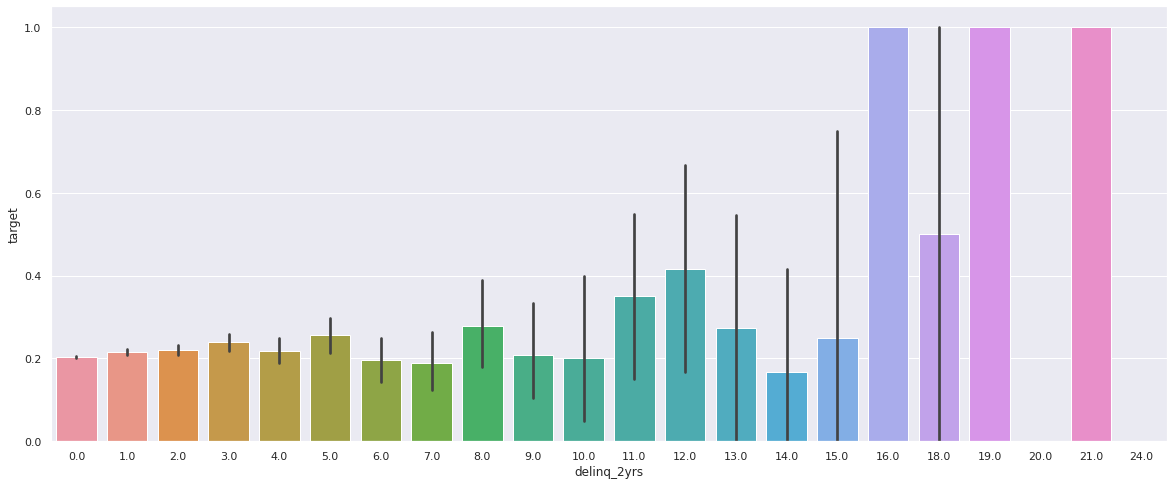

In [53]:
sns.barplot(x='delinq_2yrs', y='target', data=df)
plt.show()

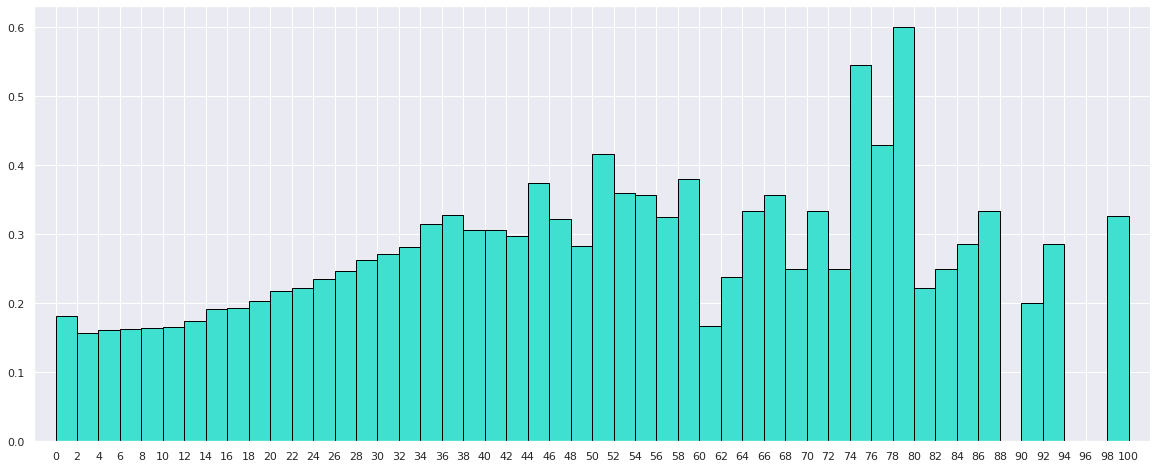

In [54]:
a = df.dti
b = df.target
bins = np.linspace(a.min(), a.max() + 1e-12, 51) # 10 bins, so 11 bin boundaries
c = np.digitize(a, bins)
plt.bar(bins[:-1], [np.mean(b[c == i]) for i in range(1, len(bins))],
        width=bins[1] - bins[0], align='edge', fc='turquoise', ec='black')
plt.xticks(bins)
plt.margins(x=0.02) # smaller margins
plt.show()

### 5. Train-test split, missing values and feature engineering

In this section I fill missing values from train set and encode categorical features.

Depending of feature type, I use three encoding types:

- Target encoding. I do it for feature with more than 5 unique values.
- One-hot encoding. I use it for features with less than 5 unique values.
- Frequency encoding. 'Title' feature only.

In [55]:
display(df.count())

id                                124598
loan_amnt                         124598
funded_amnt                       124598
funded_amnt_inv                   124598
term                              124598
int_rate                          124598
installment                       124598
purpose                           124598
title                             123212
initial_list_status               124598
application_type                  124598
grade                             124598
sub_grade                         124598
fico_range_high                   124598
emp_title                         116113
emp_length                        117004
home_ownership                    124598
annual_inc                        124598
zip_code                          124598
addr_state                        124598
dti                               124522
verification_status               124598
mo_sin_rcnt_tl                    124598
mths_since_last_delinq            124598
mths_since_last_

In [56]:
features_fill_M = ['emp_title', 'title']
features_fill_med = ['dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 
                     'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'bc_open_to_buy','tot_cur_bal_inc', 'total_rev_inc',
                    'total_bal_ex_mort_inc', 'pct_tl_nvr_dlq', 'percent_bc_gt_75']
features_fill_zero = ['open_rv_12m', 'open_il_12m', 'emp_length', 'num_tl_90g_dpd_24m', 
                      'num_tl_30dpd', 'num_tl_120dpd_2m', 'num_accts_ever_120_pd',
                     'acc_open_past_24mths']

for col in features_fill_zero:
    df[col] = df[col].fillna(value=0)

for col in features_fill_M:
    df[col] = df[col].cat.add_categories(['MISSING']) 
    df[col] = df[col].fillna(value='MISSING')
    
test_size = 0.25
df.reset_index(inplace=True, drop=True)
test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
train = df.iloc[list(set(df.index)-set(test_index))]
test = df.iloc[test_index]
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
test00 = test.copy()
train.drop(columns=['id'],inplace=True)
test.drop(columns=['id'],inplace=True)
display(train.shape, test.shape, train.head(3), test.head(3))

for col in features_fill_med:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())
    
df['total_cur_bal'] = df.tot_cur_bal_inc.median()*df.annual_inc
df['total_rev_hi_lim'] = df.total_rev_inc.median()*df.annual_inc
df['total_bal_ex_mort'] = df.total_bal_ex_mort_inc.median()*df.annual_inc


display(train.count())

(93449, 77)

(31149, 77)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
0,5000.0,5000.0,5000.0,36.0,8.67,158.240005,major_purchase,Major purchase,f,Individual,B,B1,679.0,truck driver,10.0,RENT,65000.0,488,MI,15.120000,Source Verified,4.0,1200.0,1200.0,74.0,1200.0,1200.0,2.0,2.0,0.0,0.0,6.0,4.0,1.0,17.0,6268.0,31338.0,3332.0,40.1,617.0,4.0,2.0,4.0,8300.0,0.0,0.0,0.0,2.0,2.0,31338.0,0.0,0.0,100.0,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,1.0,2015.0,20.000411,0.099998,0.0,0.076923,0.029214,0,0.051262,0.096431,0.482123,0.482123,0.127692,0,0.352941,1
1,15000.0,15000.0,14975.0,60.0,16.99,372.709991,debt_consolidation,Debt consolidation,f,Individual,D,D1,674.0,Produce Manager,10.0,RENT,47000.0,532,WI,7.430000,Source Verified,9.0,51.0,52.0,40.0,1200.0,1200.0,1.0,0.0,0.0,0.0,9.0,4.0,0.0,15.0,1252.0,11266.0,11190.0,62.5,3550.0,9.0,7.0,8.0,17900.0,0.0,0.0,0.0,3.0,0.0,11266.0,0.0,0.0,25.0,93.300003,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,1.0,2014.0,15.000992,0.199987,0.0,0.319149,0.095160,0,0.238085,0.026638,0.239702,0.239702,0.380851,0,0.600000,0
2,10000.0,10000.0,10000.0,36.0,23.99,392.279999,home_improvement,Home improvement,f,Individual,E,E2,699.0,Buyer,10.0,MORTGAGE,50000.0,333,FL,17.280001,Source Verified,1.0,27.0,52.0,1200.0,1200.0,1200.0,3.0,2.0,2.0,5.0,8.0,8.0,2.0,13.0,10375.0,83003.0,2604.0,42.0,2086.0,1.0,5.0,5.0,6200.0,0.0,0.0,0.0,0.0,0.0,21284.0,0.0,0.0,0.0,84.599998,3.0,0.0,0.0,0.0,0.0,1.0,2017.0,4.0,2017.0,11.000910,0.000000,1.0,0.200000,0.094147,0,0.052080,0.207500,1.660060,0.425680,0.124000,0,0.615385,0


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
0,35000.0,35000.0,35000.0,36.0,11.06,1146.849976,debt_consolidation,Debt consolidation,w,Individual,B,B3,664.0,Licensed Clinical Social Worker,4.0,MORTGAGE,150000.0,464,IN,15.140000,Source Verified,13.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,1.0,0.0,2.0,21.0,1.0,4.0,27.0,9681.0,203296.0,27175.0,73.6,1390.0,28.0,15.0,16.0,36900.0,0.0,0.0,0.0,0.0,0.0,97576.0,1290.0,0.0,66.699997,100.0,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,7.0,2018.0,12.334271,0.0,1.0,0.233333,0.091748,0,0.181167,0.064540,1.355307,0.650507,0.246000,0,0.777778,0
1,10000.0,10000.0,10000.0,36.0,8.24,314.480011,major_purchase,Major purchase,w,Individual,B,B1,724.0,Vice president,8.0,MORTGAGE,180000.0,117,NY,21.410000,Not Verified,2.0,53.0,81.0,1200.0,81.0,81.0,3.0,1.0,3.0,2.0,13.0,5.0,4.0,25.0,33036.0,429470.0,15911.0,68.0,7489.0,24.0,4.0,4.0,23400.0,0.0,0.0,0.0,0.0,0.0,138820.0,0.0,0.0,0.000000,88.0,0.0,2.0,0.0,0.0,0.0,0.0,2017.0,5.0,2017.0,20.082548,0.0,0.0,0.055556,0.020965,0,0.088394,0.183533,2.385944,0.771222,0.130000,0,0.520000,0
2,25000.0,25000.0,25000.0,36.0,13.06,843.080017,debt_consolidation,Debt consolidation,w,Individual,C,C1,674.0,steamfitter foreman,2.0,MORTGAGE,120000.0,152,PA,28.700001,Source Verified,21.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,18.0,2.0,1.0,31.0,22102.0,397851.0,61817.0,85.0,6902.0,21.0,12.0,12.0,72470.0,0.0,0.0,0.0,0.0,0.0,296403.0,0.0,0.0,90.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,5.0,2018.0,35.168416,0.0,0.0,0.208333,0.084308,0,0.515142,0.184183,3.315425,2.470025,0.603917,0,0.580645,0


loan_amnt                         93449
funded_amnt                       93449
funded_amnt_inv                   93449
term                              93449
int_rate                          93449
installment                       93449
purpose                           93449
title                             93449
initial_list_status               93449
application_type                  93449
grade                             93449
sub_grade                         93449
fico_range_high                   93449
emp_title                         93449
emp_length                        93449
home_ownership                    93449
annual_inc                        93449
zip_code                          93449
addr_state                        93449
dti                               93449
verification_status               93449
mo_sin_rcnt_tl                    93449
mths_since_last_delinq            93449
mths_since_last_major_derog       93449
mths_since_last_record            93449


In [57]:
train.percent_bc_gt_75.describe()

count    93449.000000
mean        42.676121
std         35.468643
min          0.000000
25%          0.000000
50%         40.000000
75%         66.699997
max        100.000000
Name: percent_bc_gt_75, dtype: float64

### Categorical features encoding

In [58]:
# TE for categorical features

time1 = time.time()
encoder = CrossFoldEncoder(MEstimateEncoder, m=10)
train_encoded = encoder.fit_transform(train, train.target, cols=cat_features_te)
test_encoded = encoder.transform(test)

freq_enc = (train.groupby('title').size()) / len(train)
train['title_fencoded'] = train['title'].apply(lambda x : freq_enc[x])
test['title_fencoded'] = test['title'].apply(lambda x : freq_enc[x])

train.drop(columns=cat_features_te, inplace=True)
test.drop(columns=cat_features_te,  inplace=True)
train = pd.concat([train, train_encoded], axis = 1)
test = pd.concat([test, test_encoded], axis = 1)

display(time.time()-time0, time.time()-time1)
display(train.shape, train.head(), train.count())
train0 = train.copy()
test0 = test.copy()

40.02329778671265

2.9231162071228027

(93449, 78)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,fico_range_high,emp_length,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,title_fencoded,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,grade_encoded,home_ownership_encoded
0,5000.0,5000.0,5000.0,36.0,8.67,158.240005,f,Individual,679.0,10.0,65000.0,15.120000,Source Verified,4.0,1200.0,1200.0,74.0,1200.0,1200.0,2.0,2.0,0.0,0.0,6.0,4.0,1.0,17.0,6268.0,31338.0,3332.0,40.1,617.0,4.0,2.0,4.0,8300.0,0.0,0.0,0.0,2.0,2.0,31338.0,0.0,0.0,100.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,1.0,2015.0,20.000411,0.099998,0.0,0.076923,0.029214,0,0.051262,0.096431,0.482123,0.482123,0.127692,0,0.352941,1,0.018181,0.108304,0.264324,0.200444,0.209235,0.195144,0.204762,0.142634,0.246198
1,15000.0,15000.0,14975.0,60.0,16.99,372.709991,f,Individual,674.0,10.0,47000.0,7.430000,Source Verified,9.0,51.0,52.0,40.0,1200.0,1200.0,1.0,0.0,0.0,0.0,9.0,4.0,0.0,15.0,1252.0,11266.0,11190.0,62.5,3550.0,9.0,7.0,8.0,17900.0,0.0,0.0,0.0,3.0,0.0,11266.0,0.0,0.0,25.000000,93.300003,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,1.0,2014.0,15.000992,0.199987,0.0,0.319149,0.095160,0,0.238085,0.026638,0.239702,0.239702,0.380851,0,0.600000,0,0.503408,0.295311,0.219685,0.222835,0.229316,0.238911,0.198103,0.344843,0.246198
2,10000.0,10000.0,10000.0,36.0,23.99,392.279999,f,Individual,699.0,10.0,50000.0,17.280001,Source Verified,1.0,27.0,52.0,1200.0,1200.0,1200.0,3.0,2.0,2.0,5.0,8.0,8.0,2.0,13.0,10375.0,83003.0,2604.0,42.0,2086.0,1.0,5.0,5.0,6200.0,0.0,0.0,0.0,0.0,0.0,21284.0,0.0,0.0,0.000000,84.599998,3.0,0.0,0.0,0.0,0.0,1.0,2017.0,4.0,2017.0,11.000910,0.000000,1.0,0.200000,0.094147,0,0.052080,0.207500,1.660060,0.425680,0.124000,0,0.615385,0,0.060900,0.439253,0.272408,0.179649,0.182870,0.215743,0.224880,0.453100,0.175271
3,2400.0,2400.0,2400.0,36.0,11.49,79.139999,w,Individual,674.0,7.0,65000.0,24.020000,Verified,8.0,23.0,23.0,1200.0,1200.0,1200.0,5.0,0.0,2.0,2.0,16.0,14.0,1.0,24.0,11994.0,191908.0,31592.0,58.1,5914.0,8.0,9.0,13.0,54400.0,1.0,0.0,0.0,0.0,0.0,51317.0,0.0,0.0,33.299999,95.800003,4.0,0.0,1.0,0.0,0.0,1.0,2016.0,6.0,2016.0,12.501283,0.000000,0.0,0.036923,0.014610,0,0.486031,0.184523,2.952431,0.789492,0.836923,0,0.666667,0,0.006688,0.182297,0.323024,0.154885,0.152733,0.196966,0.228392,0.142634,0.216833
4,3200.0,3200.0,3200.0,36.0,8.99,101.750000,w,Individual,679.0,10.0,52000.0,16.330000,Not Verified,4.0,9.0,1200.0,33.0,1200.0,9.0,1.0,0.0,0.0,0.0,8.0,4.0,0.0,12.0,1835.0,14679.0,5649.0,30.5,8981.0,4.0,7.0,7.0,18500.0,2.0,0.0,0.0,1.0,0.0,14679.0,0.0,1.0,0.000000,66.699997,1.0,0.0,0.0,0.0,0.0,0.0,2016.0,10.0,2016.0,18.083876,0.055298,0.0,0.061538,0.023481,0,0.108635,0.035288,0.282288,0.282288,0.355769,0,0.666667,0,0.199403,0.108304,0.172966,0.174786,0.180347,0.198114,0.224756,0.142634,0.175271


loan_amnt                         93449
funded_amnt                       93449
funded_amnt_inv                   93449
term                              93449
int_rate                          93449
installment                       93449
initial_list_status               93449
application_type                  93449
fico_range_high                   93449
emp_length                        93449
annual_inc                        93449
dti                               93449
verification_status               93449
mo_sin_rcnt_tl                    93449
mths_since_last_delinq            93449
mths_since_last_major_derog       93449
mths_since_last_record            93449
mths_since_recent_bc_dlq          93449
mths_since_recent_revol_delinq    93449
num_tl_op_past_12m                93449
inq_last_6mths                    93449
inq_fi                            93449
inq_last_12m                      93449
open_acc                          93449
acc_open_past_24mths              93449


In [59]:
X_train = train.copy()
y_train = X_train.pop('target')
X_test = test.copy()
y_test = X_test.pop('target')
display(X_test.head())

### Do OHE for some features ###

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), cat_features_ohe)], remainder="passthrough")

print('Number of features before transaformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
X_train.columns = X_train.columns.str.replace(r'^cat__', '').str.replace(r'^remainder__', '')
X_test.columns = X_test.columns.str.replace(r'^cat__', '').str.replace(r'^remainder__', '')
#X_train.columns = [x.strip_prefix('remainder__').strip_prefix('cat__') for x in X_train.columns]
#X_test.columns = [x.strip_prefix('remainder__').strip_prefix('cat__') for x in X_test.columns]

print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transaformation: ', X_train.shape)
X_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,fico_range_high,emp_length,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,title_fencoded,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,grade_encoded,home_ownership_encoded
0,35000.0,35000.0,35000.0,36.0,11.06,1146.849976,w,Individual,664.0,4.0,150000.0,15.140000,Source Verified,13.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,1.0,0.0,2.0,21.0,1.0,4.0,27.0,9681.0,203296.0,27175.0,73.6,1390.0,28.0,15.0,16.0,36900.0,0.0,0.0,0.0,0.0,0.0,97576.0,1290.0,0.0,66.699997,100.0,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,7.0,2018.0,12.334271,0.0,0.233333,0.091748,0,0.181167,0.064540,1.355307,0.650507,0.246000,0,0.777778,0,0.503408,0.138749,0.169584,0.222395,0.228743,0.216992,0.218820,0.141228,0.176401
1,10000.0,10000.0,10000.0,36.0,8.24,314.480011,w,Individual,724.0,8.0,180000.0,21.410000,Not Verified,2.0,53.0,81.0,1200.0,81.0,81.0,3.0,1.0,3.0,2.0,13.0,5.0,4.0,25.0,33036.0,429470.0,15911.0,68.0,7489.0,24.0,4.0,4.0,23400.0,0.0,0.0,0.0,0.0,0.0,138820.0,0.0,0.0,0.000000,88.0,0.0,2.0,0.0,0.0,0.0,0.0,2017.0,5.0,2017.0,20.082548,0.0,0.055556,0.020965,0,0.088394,0.183533,2.385944,0.771222,0.130000,0,0.520000,0,0.018181,0.108404,0.185121,0.208115,0.218844,0.227223,0.227907,0.141228,0.176401
2,25000.0,25000.0,25000.0,36.0,13.06,843.080017,w,Individual,674.0,2.0,120000.0,28.700001,Source Verified,21.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,18.0,2.0,1.0,31.0,22102.0,397851.0,61817.0,85.0,6902.0,21.0,12.0,12.0,72470.0,0.0,0.0,0.0,0.0,0.0,296403.0,0.0,0.0,90.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,5.0,2018.0,35.168416,0.0,0.208333,0.084308,0,0.515142,0.184183,3.315425,2.470025,0.603917,0,0.580645,0,0.503408,0.188940,0.207493,0.222395,0.228743,0.185493,0.210604,0.235436,0.176401
3,13825.0,13825.0,13825.0,36.0,12.99,465.760010,f,Individual,784.0,1.0,65000.0,16.730000,Source Verified,9.0,1200.0,1200.0,1200.0,1200.0,1200.0,2.0,1.0,0.0,0.0,10.0,5.0,0.0,19.0,10183.0,101829.0,339.0,2.9,11461.0,20.0,3.0,4.0,11800.0,0.0,0.0,0.0,0.0,0.0,101829.0,0.0,0.0,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,5.0,2014.0,6.414916,0.0,0.212692,0.085986,0,0.005215,0.156662,1.566600,1.566600,0.181538,0,0.526316,0,0.008486,0.188940,0.193341,0.319787,0.330836,0.222094,0.218820,0.235436,0.244336
4,12000.0,12000.0,12000.0,60.0,13.44,275.750000,w,Individual,694.0,10.0,55000.0,6.550000,Source Verified,48.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,6.0,2520.0,10078.0,10078.0,99.8,50.0,48.0,3.0,4.0,10100.0,0.0,0.0,0.0,0.0,0.0,10078.0,0.0,0.0,100.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,2016.0,1.0,2016.0,13.837382,0.0,0.218182,0.060164,0,0.183236,0.045818,0.183236,0.183236,0.183636,0,0.666667,0,0.503408,0.242545,0.155493,0.222395,0.228743,0.287606,0.227907,0.235436,0.244336


Number of features before transaformation:  (93449, 77)
time to do feature proprocessing:  3.3754465579986572
Number of features after transaformation:  (93449, 79)


,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,initial_list_status_w,application_type_Joint App,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,fico_range_high,emp_length,annual_inc,dti,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,title_fencoded,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,grade_encoded,home_ownership_encoded
0,0.0,1.0,0.0,0.0,0.0,5000.0,5000.0,5000.0,36.0,8.67,158.240005,679.0,10.0,65000.0,15.120000,4.0,1200.0,1200.0,74.0,1200.0,1200.0,2.0,2.0,0.0,0.0,6.0,4.0,1.0,17.0,6268.0,31338.0,3332.0,40.1,617.0,4.0,2.0,4.0,8300.0,0.0,0.0,0.0,2.0,2.0,31338.0,0.0,0.0,100.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,1.0,2015.0,20.000411,0.099998,0.076923,0.029214,0.0,0.051262,0.096431,0.482123,0.482123,0.127692,0.0,0.352941,1.0,0.018181,0.108304,0.264324,0.200444,0.209235,0.195144,0.204762,0.142634,0.246198
1,0.0,1.0,0.0,0.0,0.0,15000.0,15000.0,14975.0,60.0,16.99,372.709991,674.0,10.0,47000.0,7.430000,9.0,51.0,52.0,40.0,1200.0,1200.0,1.0,0.0,0.0,0.0,9.0,4.0,0.0,15.0,1252.0,11266.0,11190.0,62.5,3550.0,9.0,7.0,8.0,17900.0,0.0,0.0,0.0,3.0,0.0,11266.0,0.0,0.0,25.000000,93.300003,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,1.0,2014.0,15.000992,0.199987,0.319149,0.095160,0.0,0.238085,0.026638,0.239702,0.239702,0.380851,0.0,0.600000,0.0,0.503408,0.295311,0.219685,0.222835,0.229316,0.238911,0.198103,0.344843,0.246198
2,0.0,1.0,0.0,0.0,0.0,10000.0,10000.0,10000.0,36.0,23.99,392.279999,699.0,10.0,50000.0,17.280001,1.0,27.0,52.0,1200.0,1200.0,1200.0,3.0,2.0,2.0,5.0,8.0,8.0,2.0,13.0,10375.0,83003.0,2604.0,42.0,2086.0,1.0,5.0,5.0,6200.0,0.0,0.0,0.0,0.0,0.0,21284.0,0.0,0.0,0.000000,84.599998,3.0,0.0,0.0,0.0,0.0,1.0,2017.0,4.0,2017.0,11.000910,0.000000,0.200000,0.094147,0.0,0.052080,0.207500,1.660060,0.425680,0.124000,0.0,0.615385,0.0,0.060900,0.439253,0.272408,0.179649,0.182870,0.215743,0.224880,0.453100,0.175271
3,0.0,0.0,1.0,1.0,0.0,2400.0,2400.0,2400.0,36.0,11.49,79.139999,674.0,7.0,65000.0,24.020000,8.0,23.0,23.0,1200.0,1200.0,1200.0,5.0,0.0,2.0,2.0,16.0,14.0,1.0,24.0,11994.0,191908.0,31592.0,58.1,5914.0,8.0,9.0,13.0,54400.0,1.0,0.0,0.0,0.0,0.0,51317.0,0.0,0.0,33.299999,95.800003,4.0,0.0,1.0,0.0,0.0,1.0,2016.0,6.0,2016.0,12.501283,0.000000,0.036923,0.014610,0.0,0.486031,0.184523,2.952431,0.789492,0.836923,0.0,0.666667,0.0,0.006688,0.182297,0.323024,0.154885,0.152733,0.196966,0.228392,0.142634,0.216833
4,1.0,0.0,0.0,1.0,0.0,3200.0,3200.0,3200.0,36.0,8.99,101.750000,679.0,10.0,52000.0,16.330000,4.0,9.0,1200.0,33.0,1200.0,9.0,1.0,0.0,0.0,0.0,8.0,4.0,0.0,12.0,1835.0,14679.0,5649.0,30.5,8981.0,4.0,7.0,7.0,18500.0,2.0,0.0,0.0,1.0,0.0,14679.0,0.0,1.0,0.000000,66.699997,1.0,0.0,0.0,0.0,0.0,0.0,2016.0,10.0,2016.0,18.083876,0.055298,0.061538,0.023481,0.0,0.108635,0.035288,0.282288,0.282288,0.355769,0.0,0.666667,0.0,0.199403,0.108304,0.172966,0.174786,0.180347,0.198114,0.224756,0.142634,0.175271


### 6. Modeling

Here I will build 2 models to predict loan bankruptcies:

- Baseline XGBoost model (default hyperparameters).
- XGBoost model with hyperparameter optimization using Optuna.

'Train Accuracy: '

0.8546265877644491

'F1 score: '

0.5183478106718666

'ROCAUC: '

0.6783384086789562

'PRAUC: '

0.7158401489119839

'R20P: '

0.9248568702290076

'Test Accuracy: '

0.8104273010369514

'F1 score: '

0.3347977920468627

'ROCAUC: '

0.5960105998471859

'PRAUC: '

0.4596975604291682

'R20P: '

0.6142303969022265

5.034678936004639

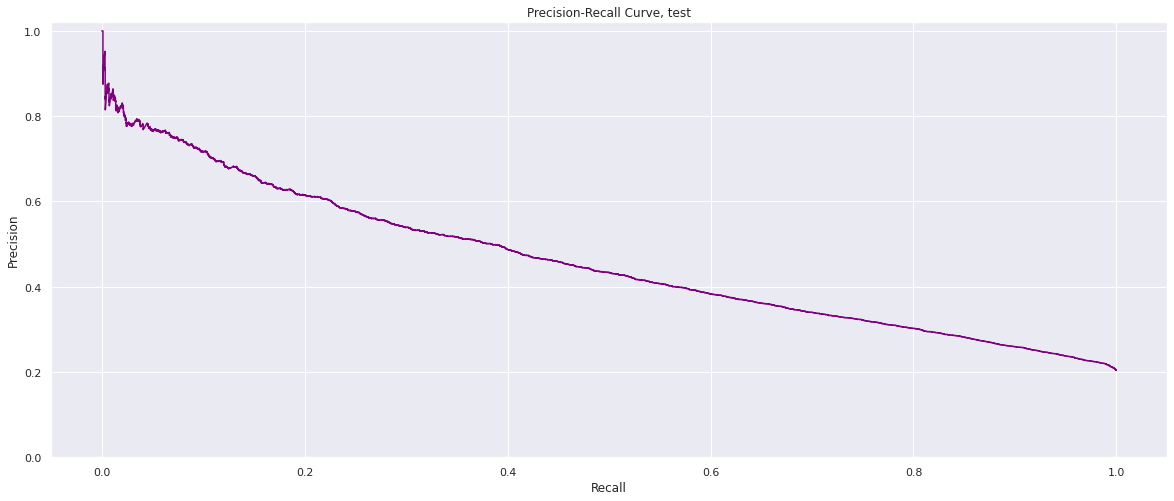

In [60]:
time1 = time.time()
xgb = XGBClassifier(tree_method = 'gpu_hist')
xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]
precision_t, recall_t, threshold = precision_recall_curve(y_test, xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

display('Train Accuracy: ', accuracy_score(y_train,xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)

# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, test')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

[I 2022-08-14 02:25:17,734] A new study created in memory with name: no-name-9cfd8433-a4bb-40e6-bf05-ecc51c9b8d4a
[I 2022-08-14 02:25:30,454] Trial 0 finished with value: 0.43090763891783823 and parameters: {'n_estimators': 1104, 'max_depth': 5, 'learning_rate': 0.18670050911655076, 'colsample_bytree': 0.8797296011443116, 'subsample': 0.9195869368624838, 'alpha': 0.2667271065930015, 'lambda': 3.054798762433389, 'gamma': 5.618432581294086e-10, 'min_child_weight': 0.11337115140859542}. Best is trial 0 with value: 0.43090763891783823.
[I 2022-08-14 02:25:38,513] Trial 1 finished with value: 0.47931022836572335 and parameters: {'n_estimators': 899, 'max_depth': 4, 'learning_rate': 0.0265237511879808, 'colsample_bytree': 0.9364644459379623, 'subsample': 0.8915448672893622, 'alpha': 5.73462579861128, 'lambda': 0.36549230327430265, 'gamma': 0.0069133108763367755, 'min_child_weight': 0.10357329235974115}. Best is trial 1 with value: 0.47931022836572335.
[I 2022-08-14 02:25:47,727] Trial 2 fini

Total time for hypermarameter optimization  431.12005519866943
        n_estimators : 1141
           max_depth : 4
       learning_rate : 0.025832134939194874
    colsample_bytree : 0.6053791851595902
           subsample : 0.8894651497113474
               alpha : 6.84295834890896
              lambda : 0.11299473200659677
               gamma : 0.00013816564699946625
    min_child_weight : 0.10398633783979029
best objective value : 0.4808427835084078


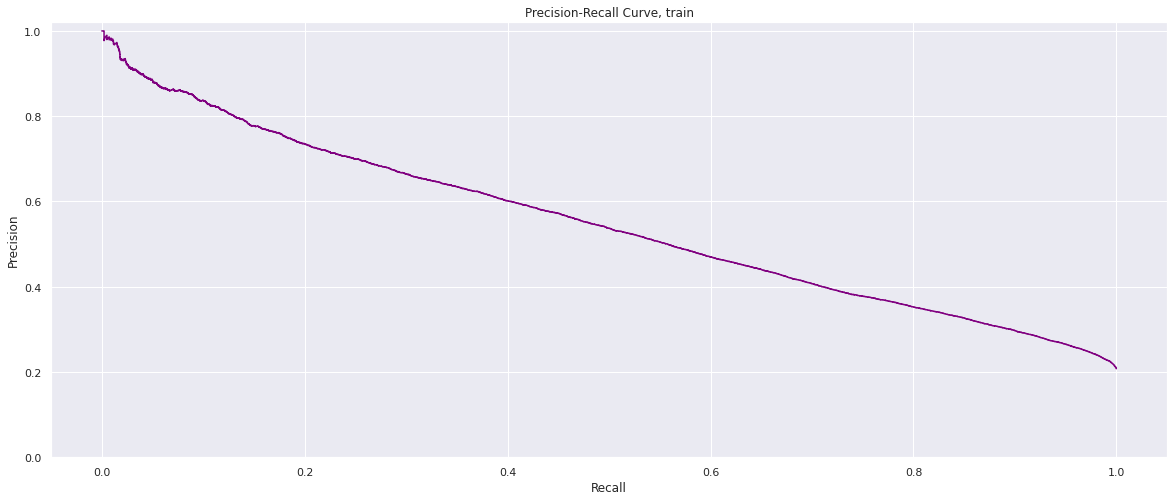

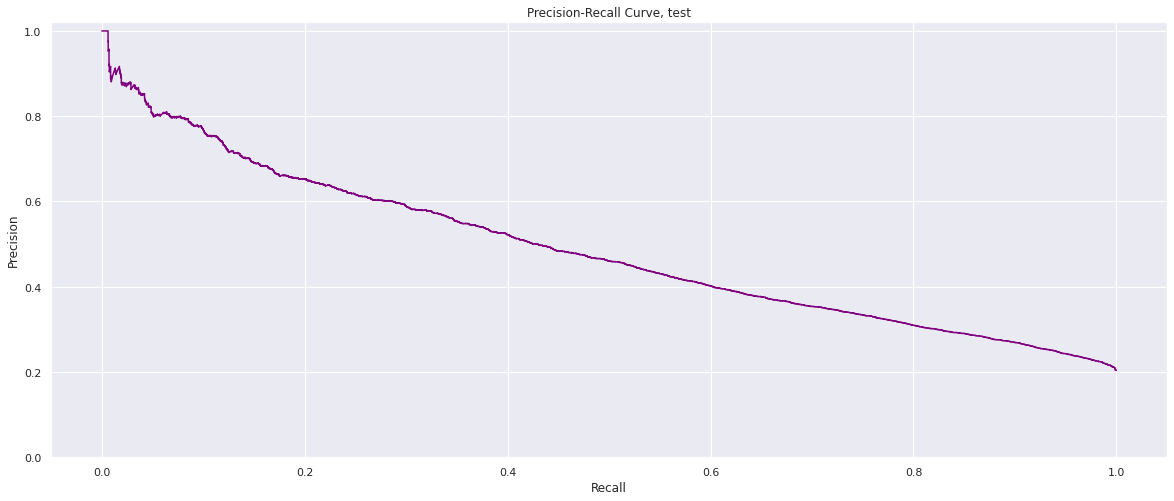

'Train Accuracy: '

0.8220205673682971

'F1 score: '

0.3660135701761073

'ROCAUC: '

0.6100078714264872

'PRAUC: '

0.5491535843303648

'R20P: '

0.7343306192009089

'Test Accuracy: '

0.8157886288484382

'F1 score: '

0.32699976542341075

'ROCAUC: '

0.5939749592247547

'PRAUC: '

0.4873885401220129

'R20P: '

0.6533127889060092

'Time to do hyperparameter optimization: '

444.31158995628357

In [61]:
### Fit XGBoost using Optuna hyperparameter optimization ###

time1 = time.time()

def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1, scale_pos_weight=2):

    cv_regularizer=0.01
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 500, 1500),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.005, 0.25),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 150.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
        "n_jobs": n_jobs,
    }
    # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
    # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
    # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

    temp_out = []

    for i in range(cv_runs):

        X = X_train
        y = y_train

        model = XGBClassifier(**params)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] += model.predict_proba(X_B)[:, 1]
            #y_pred_train[train_index] += model.predict_proba(X_A)[:, 1]
                      
        #precision_t, recall_t, threshold = precision_recall_curve(y_train, y_pred_train)
        #score_train = auc(recall_t, precision_t)
        precision_t, recall_t, threshold = precision_recall_curve(y_train, y_pred)
        score_test = auc(recall_t, precision_t)
            
        #score_train = roc_auc_score(y_train, y_pred_train)
        #score_test = roc_auc_score(y_train, y_pred) 
        #overfit = score_train-score_test
        #temp_out.append(score_test-cv_regularizer*overfit)
        temp_out.append(score_test)

    return (np.mean(temp_out))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'
optuna_hyperpars['scale_pos_weight']=1

optuna_xgb = XGBClassifier(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, optuna_xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, train')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

precision_t, recall_t, threshold = precision_recall_curve(y_test, optuna_xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, test')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

display('Train Accuracy: ', accuracy_score(y_train,optuna_xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,optuna_xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,optuna_xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)
# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,optuna_xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,optuna_xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,optuna_xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display('Time to do hyperparameter optimization: ', time.time()-time1)

### 7. Model interpretation

In [62]:
#results_fi = permutation_importance(optuna_xgb, X_test, y_test, n_jobs=-1)
#fi = pd.DataFrame({'col':X_test.columns, 'FI':results_fi.importances_mean})
#fi = fi.sort_values('FI', ascending = False)

#display(fi)

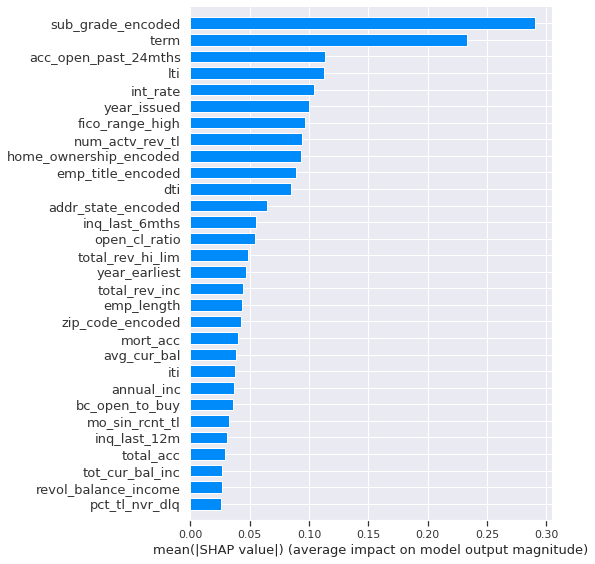

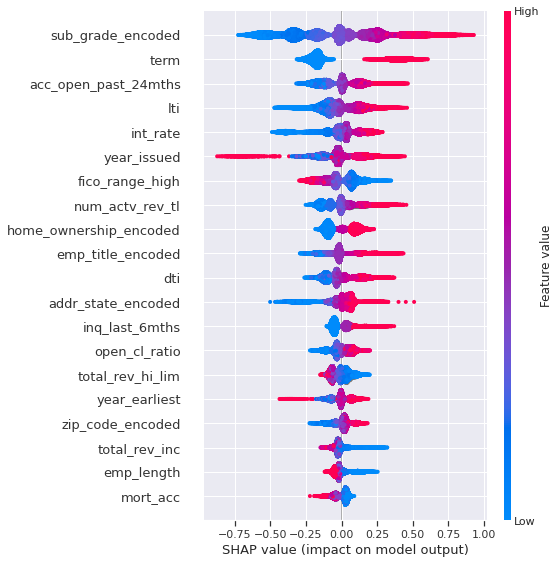

In [63]:
# template here: https://www.kaggle.com/code/kaanboke/catboost-lightgbm-xgboost-explained-by-shap/notebook
explainerxgbc = shap.TreeExplainer(optuna_xgb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)

vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)
#display(feature_importance)

shap.summary_plot(shap_values_XGBoost_test, X_test, plot_type="bar", plot_size=(8,8), max_display=30)
shap.summary_plot(shap_values_XGBoost_train, X_train,plot_type="dot", plot_size=(8,8), max_display=20)

In [64]:
#indx = 1
#fig = plt.subplots(figsize=(6,6),dpi=200)
#ax_2= shap.decision_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[indx],link= "logit")

#shap.initjs()
#shap.force_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[[indx]],link= "logit")

In [65]:
time.time()-time0

506.62415051460266

### 8. Business implications

#### 8.1 Is this model useful?

This project is a perfect illustration of how machine learning can create value if we think hard about business problem at hand rather than focusing on a few narrow model evaluation metrics.

If you view this project as a purely data mining and prediction problem, then it is arguably a failure. Model accuracy is 81% which barely beats 80% from a trivial model, always predicting no default. F1 score is only 34%, which is not impressive. ROCAUC is 59% which is not much better than a random guess.

However, the predictive model above can create value if used properly. Let me show how.

Precision-recall curve above shows that model is actually very good in predicting defaults for around one quarter of defaulted loans. For example, its precision at 20% recall is 69%. This means that if we use the model only to predict default for those loans it is most confident about, we can avoid at least 20% of credit losses while forgoing relatively few profitable lending opportunities. 

#### 8.2 How much value does it create?

While trying to quantify value created by the model, I will make a few assumptions about Lending Club business structure. They will be imperfect. The purpose of this section is to get back-of-the-envelope approximation of the increase in operational profit of Lending Club from using the model rather then build financial model of Lending Club.

The decision to refuse originating x% of the riskiest loans is a tradoeff between a foregone interest income and a credit loss. 

If Lending Club issues a loan:
- It receives interest income in the future as long as the borrower repays a loan.
- It suffers credit losses if the borrower defaults.

Thus the decision to issue such loans depends on which part dominates.

To quantify interest income, first we have to figure out cost of capital of Lending Club. Since Lending Club is not a bank, it can not borrow from the Fed at a refinance rate. It is unlikely to be able to borrow from banks at LIBOR either. I assume it can raise funding in financial markets at a rate worse than LIBOR but better than prime rate. Total cost of capital is a weighted average between cost of debt and cost of equity. Cost of equity is always higher. As of 2018, equity was around 20% of Lending Club capital. So cost of debt is the most imortant part in the cost of capital of Lending Club. Thus I assume that total cost of capital of Lending Club is roughly prime rate. Over the sample period of my data, average prime rate [was around 5%](https://fred.stlouisfed.org/series/DPRIME).

Therefore, potential interest income = Loan amount*(Interest rate-5%).

To quantify credit losses I subtract recovered amount from loan amount.

In order to keep this analysis simple and accessible to wider audience I abstract away from time discounting and present value calculations.

Thus the value created by refusing top x% riskiest (as predicted by the model) loans is $$\sum_{i \in DefaultedLoans}(LoanAmount_i - Recovery_i) - \sum_{j \in RepaidLoans}(LoanAmount_j*(InterestRate_j-5\%))$$. 





In [ ]:
X_test['y_pred'] = optuna_xgb.predict_proba(X_test)[:,1]
display(recoveries.head(), X_test.head())